In [1]:
# adapted from https://github.com/Michedev/DDPMs-Pytorch/blob/master/train.py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from omegaconf import OmegaConf
from path import Path
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import omegaconf
import hydra
from hydra import compose, initialize
import os
from matplotlib import pyplot as plt

from ddpm_tutorial.ddpm.callbacks.ema import EMA
from ddpm_tutorial.ddpm.callbacks.logger import LoggerCallback
from ddpm_tutorial.ddpm.utils.paths import MODEL

In [4]:
# Initialize configuration using Hydra
with initialize(version_base=None, config_path="../../src/ddpm_tutorial/ddpm/config"):
    config = compose(config_name="train_cifar10")

checkpoint = None  # Initialize checkpoint to None
pl.seed_everything(config.seed)  # Set seed for reproducibility

# If a checkpoint is specified in the config, load it and update the config accordingly
if config.checkpoint is not None:
    os.chdir(os.path.dirname(config.checkpoint))
    assert os.path.exists(config.checkpoint)
    checkpoint = config.checkpoint
    config = OmegaConf.load(os.path.join(os.path.dirname(checkpoint), "config.yaml"))

# Save the updated configuration to a file called 'config.yaml'
with open("config.yaml", "w") as f:
    omegaconf.OmegaConf.save(config, f)

Path.cwd().joinpath("gen_images").makedirs_p()
# copy paste model/ folder into the checkpoint folder
MODEL.copytree(Path.cwd().joinpath("model"), dirs_exist_ok=True)

/usersoftware/peerd/doughet/.conda/envs/ddpm-tutorial/lib/python3.12/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'train_cifar10': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Seed set to 1337


Path('/home/doughet/diffusion/ddpm-tutorial/docs/notebooks/model')

In [5]:
# Create the variance scheduler and a deep generative model using Hydra
scheduler = hydra.utils.instantiate(config.scheduler)
opt = hydra.utils.instantiate(config.optimizer)
model: pl.LightningModule = hydra.utils.instantiate(config.model, variance_scheduler=scheduler, opt=opt)

In [6]:
# Create training and validation datasets using Hydra
train_dataset: Dataset = hydra.utils.instantiate(config.dataset.train)
val_dataset: Dataset = hydra.utils.instantiate(config.dataset.val)

# If a checkpoint is specified, load the model weights from the checkpoint
if checkpoint is not None:
    model.load_from_checkpoint(checkpoint, variance_scheduler=scheduler)

# Save the hyperparameters of the model to a file called 'hparams.yaml'
# model.save_hyperparameters(OmegaConf.to_object(config)["model"])

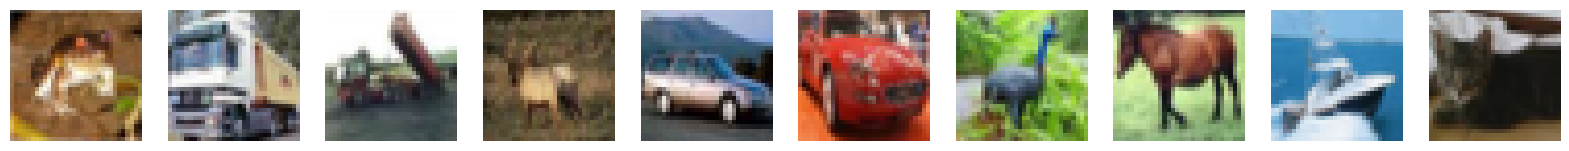

In [7]:
def show_example_images(dataset, n=10):
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
    for i in range(n):
        img = dataset[i][0].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()


show_example_images(train_dataset)

In [8]:
# Create PyTorch dataloaders for the training and validation datasets
pin_memory = "gpu" in config.accelerator
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    pin_memory=pin_memory,
    num_workers=4,
    persistent_workers=True,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=config.batch_size, pin_memory=pin_memory, num_workers=4, persistent_workers=True
)

# Create a ModelCheckpoint callback that saves the model weights to disk during training
checkpoint_callback = ModelCheckpoint(
    "./",
    "epoch={epoch}-valid_loss={val/loss_epoch}",
    monitor="val/loss_epoch",
    auto_insert_metric_name=False,
    save_last=True,
)
ddpm_logger = LoggerCallback(config.freq_logging, config.freq_logging_norm_grad, config.batch_size_gen_images)
callbacks = [checkpoint_callback, ddpm_logger]

# Add additional callbacks if specified in the configuration file
if config.ema:
    # Create an Expontential Moving Average callback
    callbacks.append(EMA(config.ema_decay))
if config.early_stop:
    callbacks.append(EarlyStopping("val/loss_epoch", min_delta=config.min_delta, patience=config.patience))

trainer = pl.Trainer(
    callbacks=callbacks,
    accelerator=config.accelerator,
    devices=config.devices if config.devices is not None else "auto",
    gradient_clip_val=config.gradient_clip_val,
    gradient_clip_algorithm=config.gradient_clip_algorithm,
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/usersoftware/peerd/doughet/.conda/envs/ddpm-tutorial/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /usersoftware/peerd/doughet/.conda/envs/ddpm-tutoria ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, train_dataloader, val_dataloader)

/usersoftware/peerd/doughet/.conda/envs/ddpm-tutorial/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usersoftware/peerd/doughet/.conda/envs/ddpm-tutorial/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/doughet/diffusion/ddpm-tutorial/docs/notebooks exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type         | Params | Mode 
---------------------------------------------------------
0 | denoiser_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Load from checkpoint

# Sample

In [10]:
model.to("cuda")
model.device

device(type='cuda', index=0)

In [13]:
X_noise = model.generate(T=1000, get_intermediate_steps=True)

In [ ]:
X_noise

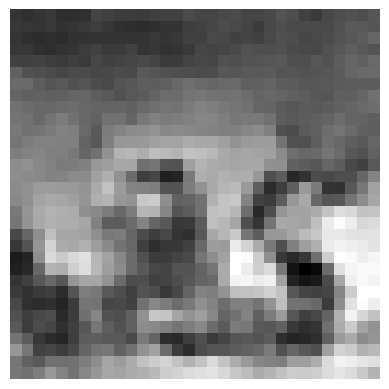

In [ ]:
import matplotlib.animation as animation
import numpy as np

f = plt.figure()
plt.axis("off")
im = plt.imshow(X_noise[0][0, 0].cpu().detach())


def update(i):
    if i >= len(X_noise):
        i = len(X_noise) - 1
    arr = X_noise[i][0, 0].cpu().detach()
    if i < len(X_noise) - 1:
        arr = (arr / 2 + 0.5).clamp(0, 1)
    im.set_array(arr)
    return [im]


interval = 1
every_nth_image = 2
anim = animation.FuncAnimation(
    f,
    update,
    frames=np.arange(0, int(len(X_noise) * 1.2), every_nth_image),
    interval=1,
    repeat=True,
    blit=True,
)
anim.save("cifar10_generation.gif", writer="pillow")

from IPython.display import HTML

HTML('<img src="cifar10_generation.gif" width="400">')